In [1]:
import os
import pathlib
import site

In [2]:
import cv2
import numpy as np

In [3]:
from pytorch_lightning import Trainer, seed_everything

In [4]:
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

OpenVINO is not installed. Please install OpenVINO to use OpenVINOInferencer.
OpenVINO is not installed. Please install OpenVINO to use OpenVINOInferencer.


To use wandb logger install it using `pip install wandb`


In [5]:
from evaluator import Evaluator

## Config

In [6]:
"""
SET MODEL NAME
"""
model_name = "padim"
config_path = f"./anomalib/models/{model_name}/config.yaml"
config = get_configurable_parameters(model_name=model_name, config_path=config_path)

/root/work/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


In [7]:
"""
DATASET SETTING 
"""
config.dataset.name = "mvtec"
config.dataset.path = "./datasets/MVTec/"
config.dataset.category = "bottle"

config.dataset.train_batch_size = 8
config.dataset.eval_batch_size = 8
config.dataset.num_workers = 0

# config.dataset.image_size =  [384, 384]

dict(config.dataset)

{'name': 'mvtec',
 'format': 'mvtec',
 'path': './datasets/MVTec/',
 'category': 'bottle',
 'task': 'segmentation',
 'train_batch_size': 8,
 'eval_batch_size': 8,
 'num_workers': 0,
 'image_size': [256, 256],
 'center_crop': None,
 'normalization': 'imagenet',
 'transform_config': {'train': None, 'eval': None},
 'test_split_mode': 'from_dir',
 'test_split_ratio': 0.2,
 'val_split_mode': 'same_as_test',
 'val_split_ratio': 0.5,
 'tiling': {'apply': False, 'tile_size': None, 'stride': None, 'remove_border_count': 0, 'use_random_tiling': False, 'random_tile_count': 16}}

In [8]:
dict(config.logging)

{'logger': [], 'log_graph': False}

In [9]:
config.metrics.pixel = []

dict(config.metrics)

{'image': ['F1Score', 'AUROC'],
 'pixel': [],
 'threshold': {'method': 'adaptive', 'manual_image': None, 'manual_pixel': None}}

In [10]:
"""
MODEL SETTING

REF: https://github.com/JohnnyHopp/PaDiM-EfficientNetV2/blob/master/main.py
"""
config.model.backbone = "resnet18"
config.model.layers = ['layer1.-1', 'layer2.-1', 'layer3.-1']
config.model.n_features = 100

# config.model.backbone = "wide_resnet50_2"
# config.model.layers = ['layer1.-1', 'layer2.-1', 'layer3.-1']
# config.model.n_features = 550

# config.model.backbone = "tf_efficientnet_b5_ns"
# config.model.layers = ['blocks.1.-1', 'blocks.3.-1', 'blocks.4.-1']
# config.model.n_features = 100

# config.model.backbone = "tf_efficientnet_b7_ns"
# config.model.layers = ['blocks.1.-1', 'blocks.3.-1', 'blocks.4.-1']
# config.model.n_features = 100

# config.model.backbone = "tf_efficientnetv2_m_in21k"
# config.model.layers = ['blocks.2.-1', 'blocks.3.-1', 'blocks.4.-1']
# config.model.n_features = 400

# config.model.backbone = "convnext_base_in22ft1k"
# config.model.layers = ['stages_0.blocks.-1', 'stages_1.blocks.-1', 'stages_2.blocks.-1']
# config.model.n_features = 600
# config.model.input_size =  [384, 384]

dict(config.model)

{'name': 'padim',
 'backbone': 'resnet18',
 'pre_trained': True,
 'layers': ['layer1.-1', 'layer2.-1', 'layer3.-1'],
 'normalization_method': 'min_max',
 'input_size': [256, 256],
 'n_features': 100}

In [11]:
dict(config.optimization)

{'export_mode': None}

In [12]:
config.project.path = f"./results/{config.dataset.category}_{model_name}_{config.model.backbone}_n{config.model.n_features}"

dict(config.project)

{'seed': 42,
 'path': './results/bottle_padim_resnet18_n100',
 'unique_dir': False}

In [13]:
config.trainer.default_root_dir = f"./results/{config.dataset.category}_{model_name}_{config.model.backbone}_n{config.model.n_features}"

dict(config.trainer)

{'enable_checkpointing': True,
 'default_root_dir': './results/bottle_padim_resnet18_n100',
 'gradient_clip_val': 0,
 'gradient_clip_algorithm': 'norm',
 'num_nodes': 1,
 'devices': 1,
 'enable_progress_bar': True,
 'overfit_batches': 0.0,
 'track_grad_norm': -1,
 'check_val_every_n_epoch': 1,
 'fast_dev_run': False,
 'accumulate_grad_batches': 1,
 'max_epochs': 1,
 'min_epochs': None,
 'max_steps': -1,
 'min_steps': None,
 'max_time': None,
 'limit_train_batches': 1.0,
 'limit_val_batches': 1.0,
 'limit_test_batches': 1.0,
 'limit_predict_batches': 1.0,
 'val_check_interval': 1.0,
 'log_every_n_steps': 50,
 'accelerator': 'auto',
 'strategy': None,
 'sync_batchnorm': False,
 'precision': 32,
 'enable_model_summary': True,
 'num_sanity_val_steps': 0,
 'profiler': None,
 'benchmark': False,
 'deterministic': False,
 'reload_dataloaders_every_n_epochs': 0,
 'auto_lr_find': False,
 'replace_sampler_ddp': True,
 'detect_anomaly': False,
 'auto_scale_batch_size': False,
 'plugins': None,
 '

In [14]:
dict(config.visualization)

{'show_images': False,
 'save_images': True,
 'log_images': True,
 'image_save_path': None,
 'mode': 'full'}

## Generate Fake Mask

In [15]:
# test_dir_path = f"{config.dataset.path}{config.dataset.category}/test/"
# ground_truth_dir_path = f"{config.dataset.path}{config.dataset.category}/ground_truth/"
# bad_labels = [d for d in os.listdir(test_dir_path) if os.path.isdir(os.path.join(test_dir_path, d)) and d != 'good']

# for bad_label in bad_labels:
#     current_test_dir_path = f"{test_dir_path}/{bad_label}/"
#     current_ground_truth_dir_path = f"{ground_truth_dir_path}/{bad_label}/"
#     img_labels = [f for f in os.listdir(current_test_dir_path) if os.path.isfile(os.path.join(current_test_dir_path, f))]

#     if not os.path.exists(current_ground_truth_dir_path):
#         os.makedirs(current_ground_truth_dir_path)
        
#     for img_label in img_labels:
#         test_img_path = f"{current_test_dir_path}{img_label}"
#         test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
        
#         black_img = np.zeros(test_img.shape, dtype=np.uint8)
        
#         black_img_path = f"{current_ground_truth_dir_path}{img_label}"
#         cv2.imwrite(black_img_path, black_img)

## Train

In [16]:
datamodule = get_datamodule(config)
model = get_model(config)
callbacks = get_callbacks(config)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/root/work/anomalib/utils/callbacks/__init__.py:142: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")


In [17]:
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_pre

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


# Test

In [18]:
weight_file_path = trainer.checkpoint_callback.best_model_path
weight_file_path

'/root/work/results/bottle_padim_resnet18_n100/weights/lightning/model-v33.ckpt'

In [19]:
load_model_callback = LoadModelCallback(weights_path=weight_file_path)
trainer.callbacks.insert(0, load_model_callback)

res=trainer.test(model=model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/root/work/anomalib/utils/callbacks/min_max_normalization.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.__df = pd.concat([self.__df, new_rows], ignore_index=True)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9944444894790649
      image_F1Score         0.9921259880065918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Check

In [20]:
# model.model

In [21]:
preds_holder = callbacks[4].get_preds_holder()
evaluator = Evaluator(df=preds_holder.dataframe)

display(f"max: {preds_holder.max}", f"min: {preds_holder.min}", f"threshold: {preds_holder.threshold}")
preds_holder.dataframe.head()

'max: 48.802703857421875'

'min: 0.08813149482011795'

'threshold: 16.479888916015625'

,image_path,pred,pred_norm,pred_label,label
0,datasets/MVTec/bottle/test/broken_large/000.png,28.595425,0.748705,1,1
1,datasets/MVTec/bottle/test/broken_large/001.png,29.478123,0.766824,1,1
2,datasets/MVTec/bottle/test/broken_large/002.png,29.309227,0.763357,1,1
3,datasets/MVTec/bottle/test/broken_large/003.png,29.624760,0.769834,1,1
4,datasets/MVTec/bottle/test/broken_large/004.png,30.032738,0.778209,1,1


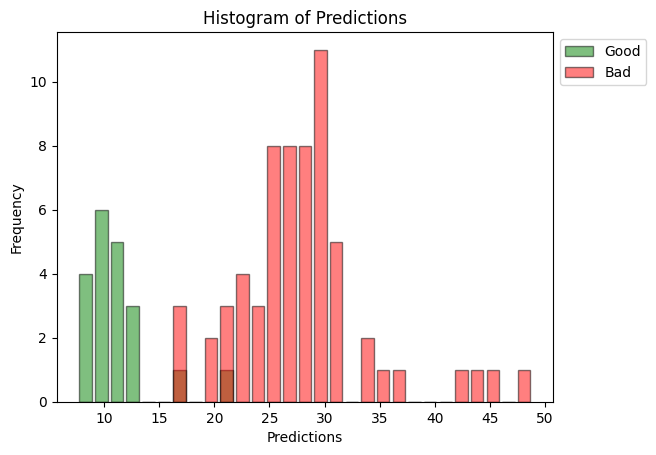

In [22]:
evaluator.show_hist()

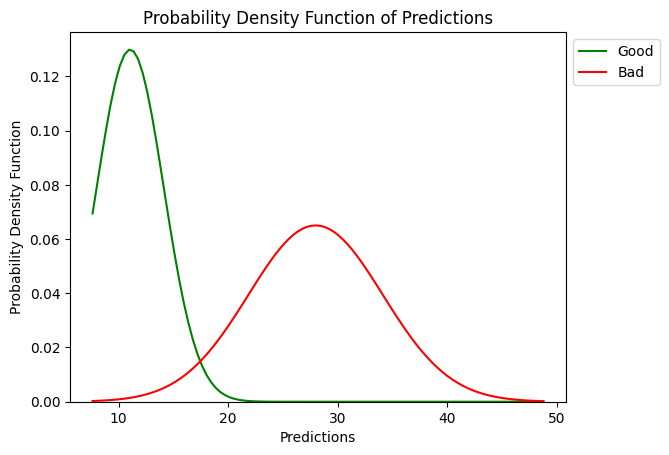

In [23]:
evaluator.show_pdf()

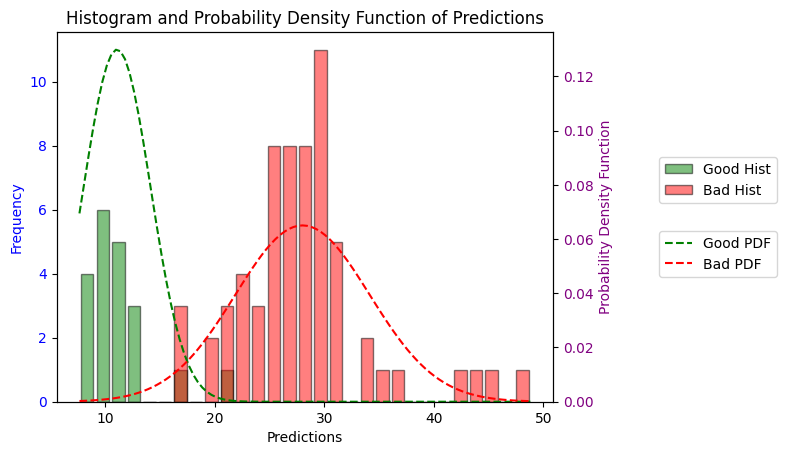

In [24]:
evaluator.show_hist_and_pdf()

In [25]:
for layer, dim, size in zip(model.model.layers, model.model.feature_extractor.out_dims, model.model.feature_extractor.out_sizes):
    print(f"{layer} [dim:{dim}, size:{size}]")

layer1.-1 [dim:64, size:64]
layer2.-1 [dim:128, size:32]
layer3.-1 [dim:256, size:16]


## Appendix

In [26]:
# import timm

In [27]:
# timm.create_model(
#     "efficientnet_b5",
#     pretrained=True,
#     features_only=True,
#     exportable=True,
# )

In [28]:
# timm.list_models(pretrained=True)